In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import matplotlib.gridspec as gridspec

# Personal python module for masks and profiles (available at github.com/cgilhuly/papers/tree/master/common)
import gilphot as gp

# Import all things needed for photutils profiles
from photutils import EllipticalAperture
from photutils.isophote import Ellipse, EllipseGeometry, EllipseSample, Isophote, IsophoteList
from photutils.isophote.isophote import Isophote, IsophoteList

from photutils.isophote import build_ellipse_model

In [2]:
# Define convenience functions for imposing contours, plotting, etc

def plot_isophotes( image, isolist, spacing = 5, log = True ):

    if log:
        plt.imshow( np.log10( image ), origin='lower' )
    else:
        plt.imshow( image, origin='lower' )
    
    rmax = isolist.sma[-1]
 
    for r in np.arange(5,rmax,spacing):
    
        iso = isolist.get_closest( r )
        x, y, = iso.sampled_coordinates()
        plt.plot(x, y, color='white')
    
    plt.show()
    
    
def fit_uniform_ellipses( image, x0, y0, phi, rmax = 0, eps = 0 ):
    
    if rmax == 0:
        rmax = 1.5 * max( np.shape( image ) )
    
    # Temporary list to store instances of Isophote
    isolist_fixed_ = []

    for rad in np.arange(1,rmax):

        # Fixed ellipse geometry + current semi-major axis length
        g = EllipseGeometry(x0, y0, rad, eps, phi)

        # Sample the image on the fixed ellipse
        sample = EllipseSample(image, g.sma, geometry=g, 
                               integrmode='median', sclip=3.0, nclip=3)
        sample.update(g)

        # Storing isophote in temporary list; arguments other than "sample" are arbitrary
        iso_ = Isophote(sample, 0, True, 0)
        isolist_fixed_.append(iso_)

    isolist_fixed = IsophoteList(isolist_fixed_)
    
    return isolist_fixed

def impose_isophotes( image, isolist_in, sclip=3.0, nclip=2 ):
    
    # Temporary list to store instances of Isophote
    isolist_temp = []

    # Loop over the IsophoteList instance 
    #
    # Note that we skip the first isophote. It's an instance of CentralEllipsePixel, 
    # which requires special sampling by the CentralEllipseSample subclass.
    for iso in isolist_in[1:]:

        g = iso.sample.geometry

        # Sample the low-S/N image at the same geometry. 
        # Should use same integration mode and same sigma-clipping settings
        sample = EllipseSample(image, g.sma, geometry=g, 
                               integrmode='median', sclip=sclip, nclip=nclip)
        sample.update(g)

        iso_ = Isophote(sample, 0, True, 0)
        isolist_temp.append(iso_)

    return IsophoteList(isolist_temp)

In [3]:
# Loading in images
fitsfile_sub = "/home/cgilhuly/Workspace/MRF/NGC4565/NGC4565_g_final.fits"
image_g_sub, header_g_sub = fits.getdata(fitsfile_sub, header=True)

fitsfile_sub = "/home/cgilhuly/Workspace/MRF/NGC4565/NGC4565_r_final.fits"
image_r_sub, header_r_sub = fits.getdata(fitsfile_sub, header=True)

# Coordinates of image centre
center_sub = (677, 677) 

# Image zeropoints (NOTE: no colour term included for g-band)
zerop_g = 27.24457 # 27.299 
zerop_r = 27.05283 # 27.032

pix_size = 2.5 # arcsec

# Loading source mask
mask_sub = fits.getdata("/home/cgilhuly/Workspace/Images/NGC4565_starsub_mask2.fits", header=False)

# Masking out already masked regions of each image (union, not intersection)
mask_sub[ image_g_sub == 0.00 ] = 1
mask_sub[ image_r_sub == 0.00 ] = 1

In [4]:
# Need to supply Ellipse with masked arrays

mask_ma = np.ma.masked_where( mask_sub > 0, mask_sub )

image_r_masked = np.ma.masked_array(image_r_sub, mask_ma.mask)
image_g_masked = np.ma.masked_array(image_g_sub, mask_ma.mask)

/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


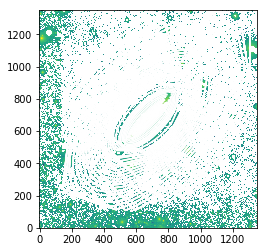

In [5]:
# Ellipse parameters for the first guess
x0 = center_sub[1]    # center position
y0 = center_sub[0]    # center position
sma = 180.            # semimajor axis length in pixels
eps = 0.65          # ellipticity
pa = 45. / 180. * np.pi

g = EllipseGeometry(x0, y0, sma, eps, pa)

ellipse_4565 = Ellipse(image_r_masked, geometry=g)

# Running the fit!
isophotes_r = ellipse_4565.fit_image(integrmode='median', step=0.05, sclip=3., nclip=2, fflag=0.25, maxsma=1000, fix_center=True)

plot_isophotes( image_r_sub, isophotes_r )

In [6]:
isophotes_g_fixed = impose_isophotes( image_g_masked, isophotes_r )

In [7]:
from skimage.morphology import erosion, dilation
from skimage.morphology import disk

mask = dilation(mask_sub,disk(3))

print( "Sky bkgd for azimuthally averaged profiles (g-band)")
skies_r, err_r, noise_r, radii = gp.measure_radial_variation( image_g_sub, initial_mask=mask, rad1=350, rad2=500, sectors=3, center=center_sub)

print( "\nSky bkgd for azimuthally averaged profiles (r-band)")
skies_r, err_r, noise_r, radii = gp.measure_radial_variation( image_r_sub, initial_mask=mask, rad1=350, rad2=500, sectors=3, center=center_sub)


sky_g_sub = -1.319
sky_g_err = 0.008
sky_g_sys = 1.319 - 1.297
sky_g_rms = 0.936

sky_r_sub = -1.402
sky_r_err = 0.009
sky_r_sys = 1.480 - 1.402
sky_r_rms = 1.045

Sky bkgd for azimuthally averaged profiles (g-band)

Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.297 +/- 0.009
mean sky = -1.240 +/- 0.007
sky RMS = 0.966

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.319 +/- 0.008
mean sky = -1.255 +/- 0.006
sky RMS = 0.936

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.343 +/- 0.008
mean sky = -1.261 +/- 0.006
sky RMS = 1.015

Sky bkgd for azimuthally averaged profiles (r-band)

Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.395 +/- 0.010
mean sky = -1.340 +/- 0.008
sky RMS = 1.065

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.402 +/- 0.009
mean sky = -1.345 +/- 0.007
sky RMS = 1.045

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.480 +/- 0.009
mean sky = -1.382 +/- 0.007
sky RMS = 1.157


/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


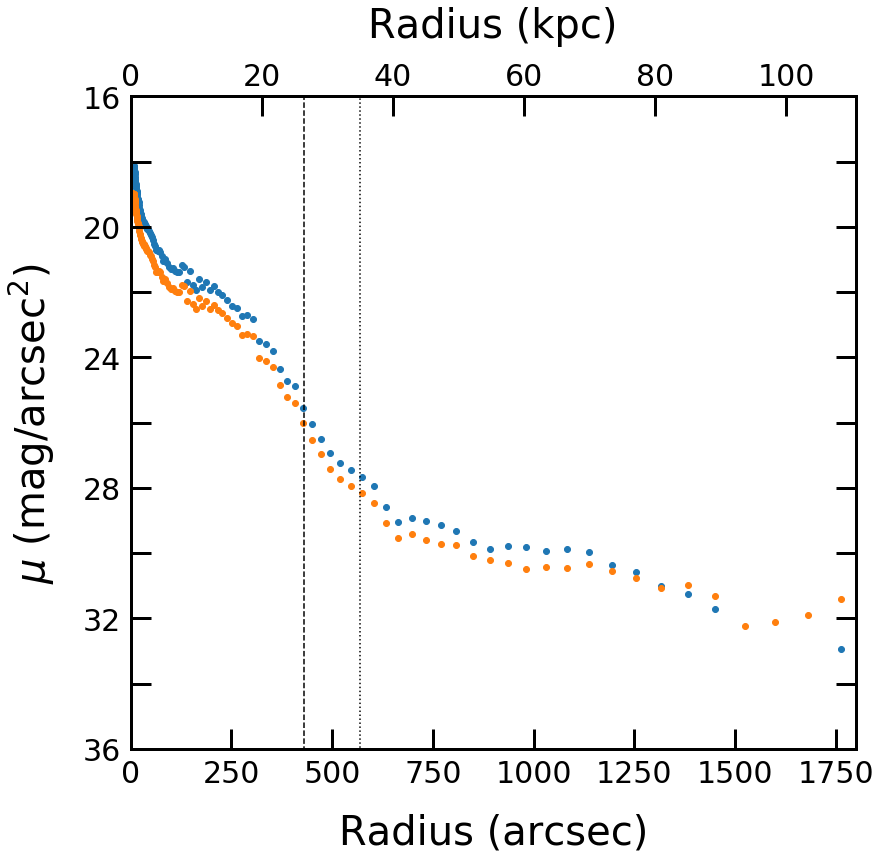

In [8]:
fig, ax = plt.subplots()

plt.scatter(isophotes_r.sma*2.5, -2.5*np.log10((isophotes_r.intens - sky_r_sub)) + zerop_r + 5*np.log10(2.5))
plt.scatter(isophotes_g_fixed.sma*2.5, -2.5*np.log10((isophotes_g_fixed.intens - sky_g_sub)) + zerop_g + 5*np.log10(2.5))
plt.gca().invert_yaxis()

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.invert_yaxis()

# Formatting ticks and plot edges 
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,110.67)  # 1800 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

ax.plot([430, 430],[10,36], 'k--')
ax.plot([570, 570],[10,36], 'k:')

ax.set_xlim(0, 1800)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36" ])

fig.set_size_inches(13, 12)

plt.show()

## Azimuthally averaged profiles restricted to quadrants

Quadrants are aligned with galaxy's major and minor axes

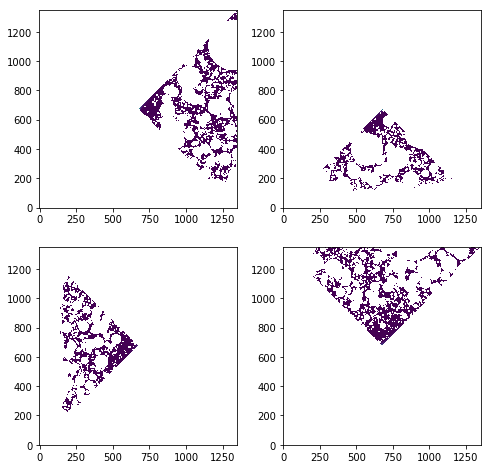

In [9]:
# Q1: West quadrant
sector_mask = gp.make_sector_mask( image_r_sub, 1.75*np.pi, 2.25*np.pi, center=(y0,x0) )
sector_mask = sector_mask + mask_sub

mask_q1 = np.ma.masked_where( sector_mask > 0, sector_mask )

image_r_masked_q1 = np.ma.masked_array(image_r_sub, mask_q1.mask)
image_g_masked_q1 = np.ma.masked_array(image_g_sub, mask_q1.mask)

# Q2: South quadrant
sector_mask = gp.make_sector_mask( image_r_sub, 0.25*np.pi, 0.75*np.pi, center=(y0,x0) )
sector_mask = sector_mask + mask_sub

mask_q2 = np.ma.masked_where( sector_mask > 0, sector_mask )

image_r_masked_q2 = np.ma.masked_array(image_r_sub, mask_q2.mask)
image_g_masked_q2 = np.ma.masked_array(image_g_sub, mask_q2.mask)

# Q3: East quadrant
sector_mask = gp.make_sector_mask( image_r_sub, 0.75*np.pi, 1.25*np.pi, center=(y0,x0) )
sector_mask = sector_mask + mask_sub

mask_q3 = np.ma.masked_where( sector_mask > 0, sector_mask )

image_r_masked_q3 = np.ma.masked_array(image_r_sub, mask_q3.mask)
image_g_masked_q3 = np.ma.masked_array(image_g_sub, mask_q3.mask)

# Q4: North quadrant
sector_mask = gp.make_sector_mask( image_r_sub, 1.25*np.pi, 1.75*np.pi, center=(y0,x0) )
sector_mask = sector_mask + mask_sub

mask_q4 = np.ma.masked_where( sector_mask > 0, sector_mask )

image_r_masked_q4 = np.ma.masked_array(image_r_sub, mask_q4.mask)
image_g_masked_q4 = np.ma.masked_array(image_g_sub, mask_q4.mask)

# Quickly showing what the quadrants look like
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(image_r_masked_q1, origin="lower")
ax[0,1].imshow(image_r_masked_q2, origin="lower")
ax[1,0].imshow(image_r_masked_q3, origin="lower")
ax[1,1].imshow(image_r_masked_q4, origin="lower")

fig.set_size_inches(8,8)
plt.show()

In [10]:
# Imposing r-band isophotal solution on quadrants
# Unable to fit shape of profile in separate quadrants
# (Plus that would be a bit strange and would make combining the quadrants problematic)

isophotes_r_q1 = impose_isophotes( image_r_masked_q1, isophotes_r )
isophotes_r_q2 = impose_isophotes( image_r_masked_q2, isophotes_r )
isophotes_r_q3 = impose_isophotes( image_r_masked_q3, isophotes_r )
isophotes_r_q4 = impose_isophotes( image_r_masked_q4, isophotes_r )

isophotes_g_q1 = impose_isophotes( image_g_masked_q1, isophotes_r )
isophotes_g_q2 = impose_isophotes( image_g_masked_q2, isophotes_r )
isophotes_g_q3 = impose_isophotes( image_g_masked_q3, isophotes_r )
isophotes_g_q4 = impose_isophotes( image_g_masked_q4, isophotes_r )

/home/cgilhuly/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.609 +/- 0.018
mean sky = -1.562 +/- 0.015
sky RMS = 0.959

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.621 +/- 0.015
mean sky = -1.560 +/- 0.012
sky RMS = 0.972

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.741 +/- 0.015
mean sky = -1.654 +/- 0.012
sky RMS = 1.000

Sector 0: radius 350.0 - 400.0 pixels
median sky = -0.749 +/- 0.022
mean sky = -0.728 +/- 0.017
sky RMS = 0.979

Sector 1: radius 400.0 - 450.0 pixels
median sky = -0.788 +/- 0.017
mean sky = -0.745 +/- 0.013
sky RMS = 0.973

Sector 2: radius 450.0 - 500.0 pixels
median sky = -0.615 +/- 0.018
mean sky = -0.537 +/- 0.014
sky RMS = 1.082

Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.262 +/- 0.017
mean sky = -1.205 +/- 0.013
sky RMS = 1.043

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.497 +/- 0.016
mean sky = -1.431 +/- 0.013
sky RMS = 0.981

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.576 +/- 0.021
mean sky = -1.465 +/- 0.017

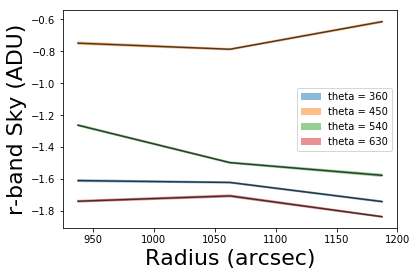

In [11]:
# Sorting out sky measurements for the quadrants

# Loop over sectors and look at radial variation within each sector
theta0 = 1.75 * np.pi
sectors = 4
delta_theta = 2*np.pi/sectors

for i in range(0, sectors):
    theta1 = theta0 + i*delta_theta
    theta2 = theta1 + delta_theta
    central_theta = (theta1 + theta2)/2. 

    sector_mask = gp.make_sector_mask( image_r_sub, theta1, theta2, center=center_sub )
    new_mask = sector_mask + mask

    skies_r, err_r, noise_r, radii = gp.measure_radial_variation( image_r_sub, initial_mask=new_mask, rad1=350, rad2=500, sectors=3, center=center_sub)
    skies_plus = [x+y/2. for x,y in zip(skies_r, err_r)] # Need to rescale
    skies_minus = [x-y/2. for x,y in zip(skies_r, err_r)]
    plt.plot(np.array(radii)*2.5, np.array(skies_r), 'k-', alpha=0.7)
    plt.fill_between(np.array(radii)*2.5, skies_plus, skies_minus, alpha=0.5, label=f"theta = {(central_theta*180./np.pi):.0f}") 

plt.xlabel("Radius (arcsec)", size=22)
plt.ylabel("r-band Sky (ADU)", size=22)
plt.legend()
plt.show()

In [12]:
sky_g_q1_sub = -1.597
sky_g_q1_err = 0.017
sky_g_q1_sys = 1.597 - 1.429

sky_g_q2_sub = -0.802
sky_g_q2_err = 0.015
sky_g_q2_sys = 0.802 - 0.657

sky_g_q3_sub = -1.380
sky_g_q3_err = 0.014
sky_g_q3_sys = 1.380- 1.213

sky_g_q4_sub = -1.480
sky_g_q4_err = 0.017
sky_g_q4_sys = 1.552 - 1.480



sky_r_q1_sub = -1.621
sky_r_q1_err = 0.015
sky_r_q1_sys = 1.738 - 1.621

sky_r_q2_sub = -0.786
sky_r_q2_err = 0.016
sky_r_q2_sys = 0.786 - 0.615

sky_r_q3_sub = -1.496
sky_r_q3_err = 0.016
sky_r_q3_sys = 1.496 - 1.262

sky_r_q4_sub = -1.705
sky_r_q4_err = 0.020
sky_r_q4_sys = 1.835 - 1.705

In [13]:
# Combining the quadrants into one big happy profile

# Finding all unique radii represented in the four quadrant profiles
rad_all_r = np.unique( np.concatenate( (isophotes_r_q1.sma, isophotes_r_q2.sma, isophotes_r_q3.sma, isophotes_r_q4.sma)) )

rad_all_g = np.unique( np.concatenate( (isophotes_g_q1.sma, isophotes_g_q2.sma, isophotes_g_q3.sma, isophotes_g_q4.sma))  )

In [14]:
SB_mag_all_r = []
SB_err_all_r_p = []
SB_err_all_r_m = []
SB_err_all_r_ps = []
SB_err_all_r_ms = []

for r in rad_all_r:

    temp_flux = 0
    temp_npix = 0
    temp_err = 0
    temp_err_sys = 0
    count = 0
    
    # Find matching entries in rad_i
    # For matches, increase flux, npix, random error, and random+sys error
    if r in isophotes_r_q1.sma:
        i = np.where( isophotes_r_q1.sma == r )[0][0]
        temp_flux += (isophotes_r_q1.intens[i] - sky_r_q1_sub)*isophotes_r_q1.ndata[i]
        temp_npix += isophotes_r_q1.ndata[i]
        temp_err += isophotes_r_q1.ndata[i]**2 *(isophotes_r_q1.int_err[i]**2 + sky_r_q1_err**2 )
        temp_err_sys += isophotes_r_q1.ndata[i]**2 *(isophotes_r_q1.int_err[i]**2 + sky_r_q1_err**2 + sky_r_q1_sys**2)
        count += 1
        
    if r in isophotes_r_q2.sma:
        i = np.where( isophotes_r_q2.sma == r )[0][0]
        temp_flux += (isophotes_r_q2.intens[i] - sky_r_q2_sub)*isophotes_r_q2.ndata[i]
        temp_npix += isophotes_r_q2.ndata[i]
        temp_err += isophotes_r_q2.ndata[i]**2 *(isophotes_r_q2.int_err[i]**2 + sky_r_q2_err**2 )
        temp_err_sys += isophotes_r_q2.ndata[i]**2 *(isophotes_r_q2.int_err[i]**2 + sky_r_q2_err**2 + sky_r_q2_sys**2)
        count += 1

    if r in isophotes_r_q3.sma:
        i = np.where( isophotes_r_q3.sma == r )[0][0]
        temp_flux += (isophotes_r_q3.intens[i] - sky_r_q3_sub)*isophotes_r_q3.ndata[i]
        temp_npix += isophotes_r_q3.ndata[i]
        temp_err += isophotes_r_q3.ndata[i]**2 *(isophotes_r_q3.int_err[i]**2 + sky_r_q3_err**2 )
        temp_err_sys += isophotes_r_q3.ndata[i]**2 *(isophotes_r_q3.int_err[i]**2 + sky_r_q3_err**2 + sky_r_q3_sys**2)
        count += 1

    if r in isophotes_r_q4.sma:
        i = np.where( isophotes_r_q4.sma == r )[0][0]
        temp_flux += (isophotes_r_q4.intens[i] - sky_r_q4_sub)*isophotes_r_q4.ndata[i]
        temp_npix += isophotes_r_q4.ndata[i]
        temp_err += isophotes_r_q4.ndata[i]**2 *(isophotes_r_q4.int_err[i]**2 + sky_r_q4_err**2 )
        temp_err_sys += isophotes_r_q4.ndata[i]**2 *(isophotes_r_q4.int_err[i]**2 + sky_r_q4_err**2 + sky_r_q4_sys**2)
        count += 1       
    
    # If at least one quadrant profile has SB measurement at current radius
    if temp_flux != 0:
        temp_flux = temp_flux / (temp_npix) # Renormalizing weighted SB 
        temp_SB = -2.5*np.log10( temp_flux ) + zerop_r + 5*np.log10(2.5)
        SB_mag_all_r.append(temp_SB)
        
        temp_err = np.sqrt( temp_err ) / ( temp_npix )
        temp_err_sys = np.sqrt( temp_err_sys ) / ( temp_npix )
        
        # Upper and lower error bars (without and with systematic uncertainty in sky)
        SB_err_all_r_m.append( -2.5*np.log10( temp_flux - temp_err ) + zerop_r + 5*np.log10(2.5) )
        SB_err_all_r_p.append( -2.5*np.log10( temp_flux + temp_err ) + zerop_r + 5*np.log10(2.5) )
        SB_err_all_r_ms.append( -2.5*np.log10( temp_flux - temp_err_sys ) + zerop_r + 5*np.log10(2.5) )
        SB_err_all_r_ps.append( -2.5*np.log10( temp_flux + temp_err_sys ) + zerop_r + 5*np.log10(2.5) )
   
    # If no quadrant profiles have SB measurement at current radius, set SB and all errors to NaN
    else:
        SB_mag_all_r.append(np.nan)
        SB_err_all_r_p.append(np.nan)
        SB_err_all_r_m.append(np.nan)
        SB_err_all_r_ps.append(np.nan)
        SB_err_all_r_ms.append(np.nan)

err_all_tmp = [np.array(SB_mag_all_r) - np.array(SB_err_all_r_p), np.array(SB_err_all_r_m) - np.array(SB_mag_all_r) ]
err_all_r = np.array( err_all_tmp )


/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


In [15]:
SB_mag_all_g = []
SB_err_all_g_p = []
SB_err_all_g_m = []
SB_err_all_g_ps = []
SB_err_all_g_ms = []

for r in rad_all_g:

    temp_flux = 0
    temp_npix = 0
    temp_err = 0
    temp_err_sys = 0
    count = 0
    
    # Find matching entries in rad_i
    # For matches, increase flux, npix, random error, and random+sys error
    if r in isophotes_g_q1.sma:
        i = np.where( isophotes_g_q1.sma == r )[0][0]
        temp_flux += (isophotes_g_q1.intens[i] - sky_g_q1_sub)*isophotes_g_q1.ndata[i]
        temp_npix += isophotes_g_q1.ndata[i]
        temp_err += isophotes_g_q1.ndata[i]**2 *(isophotes_g_q1.int_err[i]**2 + sky_g_q1_err**2 )
        temp_err_sys += isophotes_g_q1.ndata[i]**2 *(isophotes_g_q1.int_err[i]**2 + sky_g_q1_err**2 + sky_g_q1_sys**2)
        count += 1
        
    if r in isophotes_g_q2.sma:
        i = np.where( isophotes_g_q2.sma == r )[0][0]
        temp_flux += (isophotes_g_q2.intens[i] - sky_g_q2_sub)*isophotes_g_q2.ndata[i]
        temp_npix += isophotes_g_q2.ndata[i]
        temp_err += isophotes_g_q2.ndata[i]**2 *(isophotes_g_q2.int_err[i]**2 + sky_g_q2_err**2 )
        temp_err_sys += isophotes_g_q2.ndata[i]**2 *(isophotes_g_q2.int_err[i]**2 + sky_g_q2_err**2 + sky_g_q2_sys**2)
        count += 1

    if r in isophotes_g_q3.sma:
        i = np.where( isophotes_g_q3.sma == r )[0][0]
        temp_flux += (isophotes_g_q3.intens[i] - sky_g_q3_sub)*isophotes_g_q3.ndata[i]
        temp_npix += isophotes_g_q3.ndata[i]
        temp_err += isophotes_g_q3.ndata[i]**2 *(isophotes_g_q3.int_err[i]**2 + sky_g_q3_err**2 )
        temp_err_sys += isophotes_g_q3.ndata[i]**2 *(isophotes_g_q3.int_err[i]**2 + sky_g_q3_err**2 + sky_g_q3_sys**2)
        count += 1

    if r in isophotes_g_q4.sma:
        i = np.where( isophotes_g_q4.sma == r )[0][0]
        temp_flux += (isophotes_g_q4.intens[i] - sky_g_q4_sub)*isophotes_g_q4.ndata[i]
        temp_npix += isophotes_g_q4.ndata[i]
        temp_err += isophotes_g_q4.ndata[i]**2 *(isophotes_g_q4.int_err[i]**2 + sky_g_q4_err**2 )
        temp_err_sys += isophotes_g_q4.ndata[i]**2 *(isophotes_g_q4.int_err[i]**2 + sky_g_q4_err**2 + sky_g_q4_sys**2)
        count += 1       
    
    # If at least one quadrant profile has SB measurement at current radius
    if temp_flux != 0:
        temp_flux = temp_flux / (temp_npix) # Renormalizing weighted SB 
        temp_SB = -2.5*np.log10( temp_flux ) + zerop_g + 5*np.log10(2.5)
        SB_mag_all_g.append(temp_SB)
        
        temp_err = np.sqrt( temp_err ) / ( temp_npix )
        temp_err_sys = np.sqrt( temp_err_sys ) / ( temp_npix )
        
        # Upper and lower error bars (without and with systematic uncertainty in sky)
        SB_err_all_g_m.append( -2.5*np.log10( temp_flux - temp_err ) + zerop_g + 5*np.log10(2.5) )
        SB_err_all_g_p.append( -2.5*np.log10( temp_flux + temp_err ) + zerop_g + 5*np.log10(2.5) )
        SB_err_all_g_ms.append( -2.5*np.log10( temp_flux - temp_err_sys ) + zerop_g + 5*np.log10(2.5) )
        SB_err_all_g_ps.append( -2.5*np.log10( temp_flux + temp_err_sys ) + zerop_g + 5*np.log10(2.5) )
   
    # If no quadrant profiles have SB measurement at current radius, set SB and all errors to NaN
    else:
        SB_mag_all_g.append(np.nan)
        SB_err_all_g_p.append(np.nan)
        SB_err_all_g_m.append(np.nan)
        SB_err_all_g_ps.append(np.nan)
        SB_err_all_g_ms.append(np.nan)

err_all_tmp = [np.array(SB_mag_all_g) - np.array(SB_err_all_g_p), np.array(SB_err_all_g_m) - np.array(SB_mag_all_g) ]
err_all_g = np.array( err_all_tmp )

/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10


/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


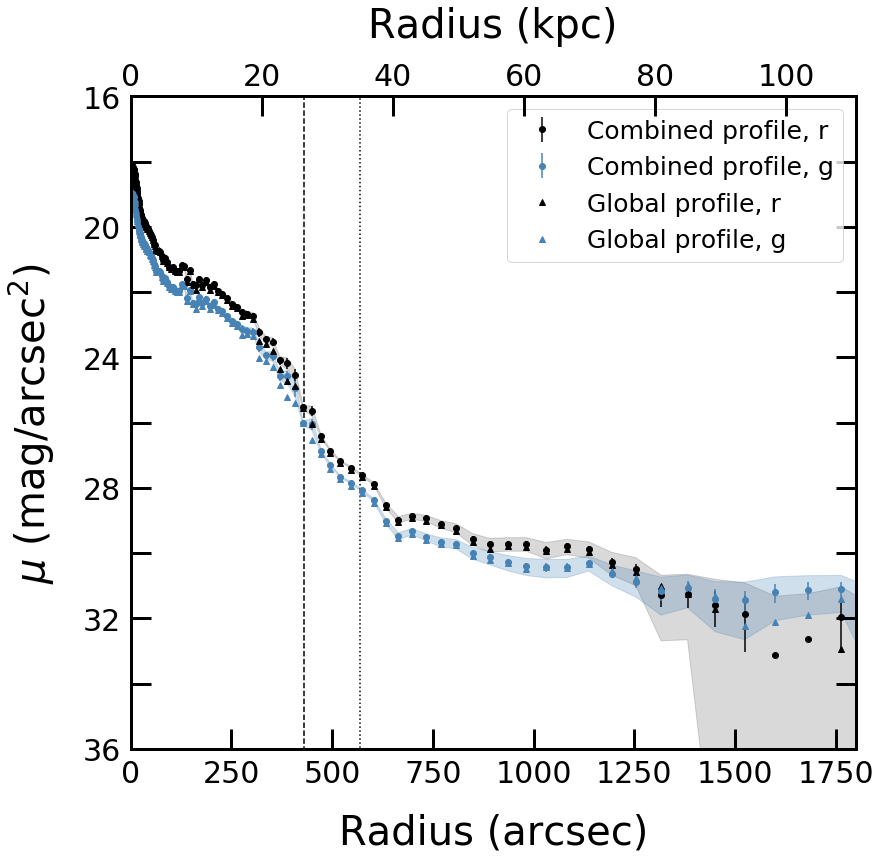

In [16]:
# Galactic extinction (Schlafly et al. 2011; accessed via NED)
extinct_g = 0.051
extinct_r = 0.035

# Setting all NaNs to something large and finite for plotting purposes
SB_err_all_r_ms = [40 if np.isnan(x) else x for x in SB_err_all_r_ms]
SB_err_all_g_ms = [40 if np.isnan(x) else x for x in SB_err_all_g_ms]

SB_err_all_r_m = [40 if np.isnan(x) else x for x in SB_err_all_r_m]
SB_err_all_g_m = [40 if np.isnan(x) else x for x in SB_err_all_g_m]

fig, ax = plt.subplots()

# Plotting combined profiles and their envelopes including systematic sky uncertainty
ax.errorbar(np.array(rad_all_r)*2.5, np.array(SB_mag_all_r) - extinct_r, yerr=err_all_r, fmt='o', c="k", label="Combined profile, r")
ax.errorbar(np.array(rad_all_g)*2.5, np.array(SB_mag_all_g) - extinct_g, yerr=err_all_g, fmt='o', c="steelblue", label="Combined profile, g")
plt.fill_between(np.array(rad_all_r)*2.5, np.array(SB_err_all_r_ps) - extinct_r, np.array(SB_err_all_r_ms) - extinct_r, alpha=0.15, color="k")
plt.fill_between(np.array(rad_all_g)*2.5, np.array(SB_err_all_g_ps) - extinct_g, np.array(SB_err_all_g_ms) - extinct_g, alpha=0.25, color="steelblue")

plt.errorbar(isophotes_r.sma*2.5, -2.5*np.log10((isophotes_r.intens - sky_r_sub)) + zerop_r + 5*np.log10(2.5), fmt='^', c="k", label="Global profile, r")
plt.errorbar(isophotes_g_fixed.sma*2.5, -2.5*np.log10((isophotes_g_fixed.intens - sky_g_sub)) + zerop_g + 5*np.log10(2.5), fmt='^', c="steelblue", label="Global profile, g")


leg = plt.legend(loc=1, prop={'size': 25})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.invert_yaxis()

# Formatting ticks and plot edges 
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,110.67)  # 1800 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

ax.plot([430, 430],[10,36], 'k--')
ax.plot([570, 570],[10,36], 'k:')

ax.set_xlim(0, 1800)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36" ])

fig.set_size_inches(13, 12)
##plt.savefig("/home/cgilhuly/Documents/NGC4565_fig2.pdf")
plt.show()

## Comparison with 2D model profiles

In [17]:
# Load in model images
fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_r_PSF_dustlane.fits"
image_r_model_PSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_r_noPSF_dustlane.fits"
image_r_model_noPSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_g_PSF_dustlane.fits"
image_g_model_PSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_g_noPSF_dustlane.fits"
image_g_model_noPSF = fits.getdata(fitsfile_model, header=False)

mask_model = np.zeros( np.shape(image_r_model_PSF) )

In [18]:
isophotes_model_fixed = impose_isophotes( image_r_model_PSF, isophotes_r )
isophotes_model_noPSF_fixed = impose_isophotes( image_r_model_noPSF, isophotes_r )

isophotes_model_g_fixed = impose_isophotes( image_g_model_PSF, isophotes_r )
isophotes_model_g_noPSF_fixed = impose_isophotes( image_g_model_noPSF, isophotes_r )

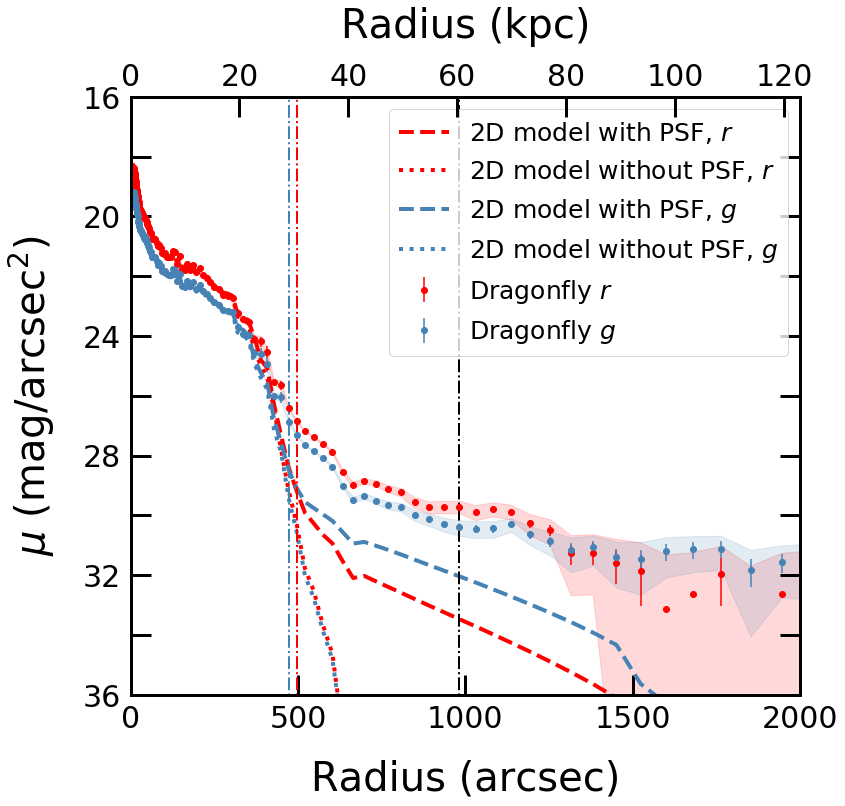

In [19]:
fig, ax = plt.subplots()

ax.errorbar(np.array(rad_all_r)*2.5, np.array(SB_mag_all_r) - extinct_r, yerr=err_all_r, fmt='o', c="r", label="Dragonfly $r$")
ax.errorbar(np.array(rad_all_g)*2.5, np.array(SB_mag_all_g) - extinct_g, yerr=err_all_g, fmt='o', c="steelblue", label="Dragonfly $g$")
plt.fill_between(np.array(rad_all_r)*2.5, np.array(SB_err_all_r_ps) - extinct_r, np.array(SB_err_all_r_ms) - extinct_r, alpha=0.15, color="r")
plt.fill_between(np.array(rad_all_g)*2.5, np.array(SB_err_all_g_ps) - extinct_g, np.array(SB_err_all_g_ms) - extinct_g, alpha=0.15, color="steelblue")


plt.plot(isophotes_model_fixed.sma*2.5, -2.5*np.log10((isophotes_model_fixed.intens - 0.0)) + zerop_r + 5*np.log10(2.5), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_noPSF_fixed.sma*2.5, -2.5*np.log10((isophotes_model_noPSF_fixed.intens - 0.0)) + zerop_r + 5*np.log10(2.5), "r:", lw=4, label="2D model without PSF, $r$")

plt.plot(isophotes_model_g_fixed.sma*2.5, -2.5*np.log10((isophotes_model_g_fixed.intens - 0.0)) + zerop_g + 5*np.log10(2.5), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
plt.plot(isophotes_model_g_noPSF_fixed.sma*2.5, -2.5*np.log10((isophotes_model_g_noPSF_fixed.intens - 0.0)) + zerop_g + 5*np.log10(2.5), ":", c="steelblue", lw=4, label="2D model without PSF, $g$")


plt.gca().invert_yaxis()

plt.legend( prop={'size': 25})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.invert_yaxis()

# Formatting ticks and plot edges 
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,122.96714666577871)  # 2000 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 2000)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36" ])

ax.plot([472.5,472.5],[0,36], '-.', c="steelblue", lw=2)
ax.plot([496.125,496.125],[0,36], 'r-.', lw=2)
ax.plot([982.2935647718718,982.2935647718718],[0,36], 'k-.', lw=2)

fig.set_size_inches(12, 11)
##plt.savefig("/home/cgilhuly/Documents/NGC4565_fig2_new.pdf")
plt.show()

In [20]:
# Measurements of model profiles

# For both bands, when does PSF profile (flux) = 2x noPSF profile (flux)? (radius and SB)
for i in range(0,len(isophotes_model_fixed.intens)):
    
    if isophotes_model_fixed.intens[i] >= 2.0 * isophotes_model_noPSF_fixed.intens[i]:
        print( f"Az-avg profile: r-band scattered light dominates over disc at {isophotes_model_fixed.sma[i]*pix_size} arcsec (SB = {-2.5*np.log10(isophotes_model_fixed.intens[i]) + zerop_r + 5*np.log10(2.5)}) ")
        print( i )
        break
    
for i in range(0,len(isophotes_model_g_fixed)):
    
    if isophotes_model_g_fixed.intens[i] >= 2.0 * isophotes_model_g_noPSF_fixed.intens[i]:
        print( f"Az-avg profile: g-band scattered light dominates over disc at {isophotes_model_g_fixed.sma[i]*pix_size} arcsec (SB = {-2.5*np.log10(isophotes_model_g_fixed.intens[i]) + zerop_g + 5*np.log10(2.5)}) ")
        print( i )
        break
        
# How does (PSF - noPSF) compare to observed profile? Estimate fraction of scattered light contribution

frac_scattered_rn = ( isophotes_model_fixed.intens[120] - isophotes_model_noPSF_fixed.intens[120] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_r - SB_mag_all_r[120] )/2.5 ) )
frac_scattered_r0 = ( isophotes_model_fixed.intens[121] - isophotes_model_noPSF_fixed.intens[121] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_r - SB_mag_all_r[121] )/2.5 ) )
frac_scattered_r1 = ( isophotes_model_fixed.intens[122] - isophotes_model_noPSF_fixed.intens[122] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_r - SB_mag_all_r[122] )/2.5 ) )
frac_scattered_r2 = ( isophotes_model_fixed.intens[136] - isophotes_model_noPSF_fixed.intens[136] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_r - SB_mag_all_r[136] )/2.5 ) )

frac_scattered_gn = ( isophotes_model_g_fixed.intens[120] - isophotes_model_g_noPSF_fixed.intens[120] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_g - SB_mag_all_g[120] )/2.5 ) )
frac_scattered_g0 = ( isophotes_model_g_fixed.intens[121] - isophotes_model_g_noPSF_fixed.intens[121] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_g - SB_mag_all_g[121] )/2.5 ) )
frac_scattered_g1 = ( isophotes_model_g_fixed.intens[122] - isophotes_model_g_noPSF_fixed.intens[122] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_g - SB_mag_all_g[122] )/2.5 ) )
frac_scattered_g2 = ( isophotes_model_g_fixed.intens[136] - isophotes_model_g_noPSF_fixed.intens[136] ) / ( np.power(10,( 5*np.log10(2.5) + zerop_g - SB_mag_all_g[136] )/2.5 ) )

print()
print( f"Estimated fraction of scattered light at {isophotes_model_fixed.sma[120]*2.5} arcsec:" )
print( f"r: {frac_scattered_rn}" )
print( f"g: {frac_scattered_gn}" )

print()
print( f"Estimated fraction of scattered light at {isophotes_model_fixed.sma[121]*2.5} arcsec:" )
print( f"r: {frac_scattered_r0}" )
print( f"g: {frac_scattered_g0}" )

print()
print( f"Estimated fraction of scattered light at {isophotes_model_fixed.sma[122]*2.5} arcsec:" )
print( f"r: {frac_scattered_r1}" )
print( f"g: {frac_scattered_g1}" )

print()
print( f"Estimated fraction of scattered light at {isophotes_model_fixed.sma[136]*2.5} arcsec:" )
print( f"r: {frac_scattered_r2}" )
print( f"g: {frac_scattered_g2}" )

Az-avg profile: r-band scattered light dominates over disc at 472.5 arcsec (SB = 28.39887534199805) 
121
Az-avg profile: g-band scattered light dominates over disc at 472.5 arcsec (SB = 28.48373164064265) 
121

Estimated fraction of scattered light at 450.0 arcsec:
r: 0.07683762638172888
g: 0.06495811606167051

Estimated fraction of scattered light at 472.5 arcsec:
r: 0.08523288728114264
g: 0.13859271210810112

Estimated fraction of scattered light at 496.12500000000006 arcsec:
r: 0.07751820106076
g: 0.1511063683553826

Estimated fraction of scattered light at 982.2935647718718 arcsec:
r: 0.032534493958925624
g: 0.23047883559473792
